# Generating new places in County Durham with WaveNet

We continue to investigate how to generate new place names in County Durham by implementing a deeper architecture based on [WaveNet](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio). WaveNet first appeared in the [paper](https://arxiv.org/pdf/1609.03499.pdf) by DeepMind as a way to generate novel musical fragments. The code used to build a WaveNet network is based on [this](https://www.youtube.com/watch?v=t3YJ5hKiMQ0) Andrej Karpathy lecture.

<font color='0789DF'>Table of contents<font><a class='anchor' id='top'></a>
- [Setting up](#settingup)
- [WaveNet architecture](#arch)
- [Setting up a hierarchical network](#settingupnetwork)
- [Building a hierarchical network](#building)
- [Training WaveNet](#train)
- [Evaluating WaveNet](#eval)
- [Sampling from WaveNet](#sample)

## Setting up <a class="anchor" id="settingup">
    
Let's load in the requisite libraries, the corpus of place names `place_names_durham.txt` and define mappings between characters and indices as we did in the approach where we used a multi-layer perceptron.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
places = open('place_names_durham.txt', 'r').read().splitlines()
print(places[:5])

['addison', 'adelaide bank', 'aislaby', 'albany', 'albert hill']


In [3]:
chars = sorted(list(set(''.join(places))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: "'", 3: '-', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 0: '.'}
30


The input to our network is a vector respresenting characters that are embedded in a certain space. For each input there is a value the network should output that gives the correct next character. The following function `build_dataset` constructs such inputs for our network with the associated true next character.

The length of the input is a parameter `block_size` that tells us the context the network is allowed to see in order to make a prediction. 

As before, we split this labelled data into a training set, a validation set and a test set in order to evaluate performance.

In [4]:
import random
random.seed(42)
random.shuffle(places)

block_size = 8

def build_dataset(places):  
    X, Y = [], []
    for w in places:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(places))
n2 = int(0.9*len(places))
Xtr,  Ytr  = build_dataset(places[:n1])     # 80%
Xdev, Ydev = build_dataset(places[n1:n2])   # 10%
Xte,  Yte  = build_dataset(places[n2:])     # 10%

torch.Size([11433, 8]) torch.Size([11433])
torch.Size([1429, 8]) torch.Size([1429])
torch.Size([1428, 8]) torch.Size([1428])


To visualise what `build_dataset` is doing, we print out the input to a network and the expected character that should be the output.

In [5]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> g
......eg --> g
.....egg --> l
....eggl --> e
...eggle --> s
..eggles --> c
.egglesc --> l
egglescl --> i
gglescli --> f
glesclif --> f
lescliff --> e
escliffe --> .
........ --> a
.......a --> l
......al --> s
.....als --> t
....alst --> o
...alsto --> n
..alston -->  


As we see above, eight characters are used to predict the next.

## WaveNet architecture <a class="anchor" id="arch">

The premise of WaveNet is to progressively break down an input into smaller contexts that are passed through many layers. 

With `block_size`=8 we will break an input into four pairs (or bigrams) that are passed through a layer. These four pairs are then fused into two pairs of quadrams and then passed through another layer. The final two pairs are then fused together and then passed through another layer. Looking at Figure 2 from the [original WaveNet paper](https://arxiv.org/pdf/1609.03499.pdf) we see how this is structured.

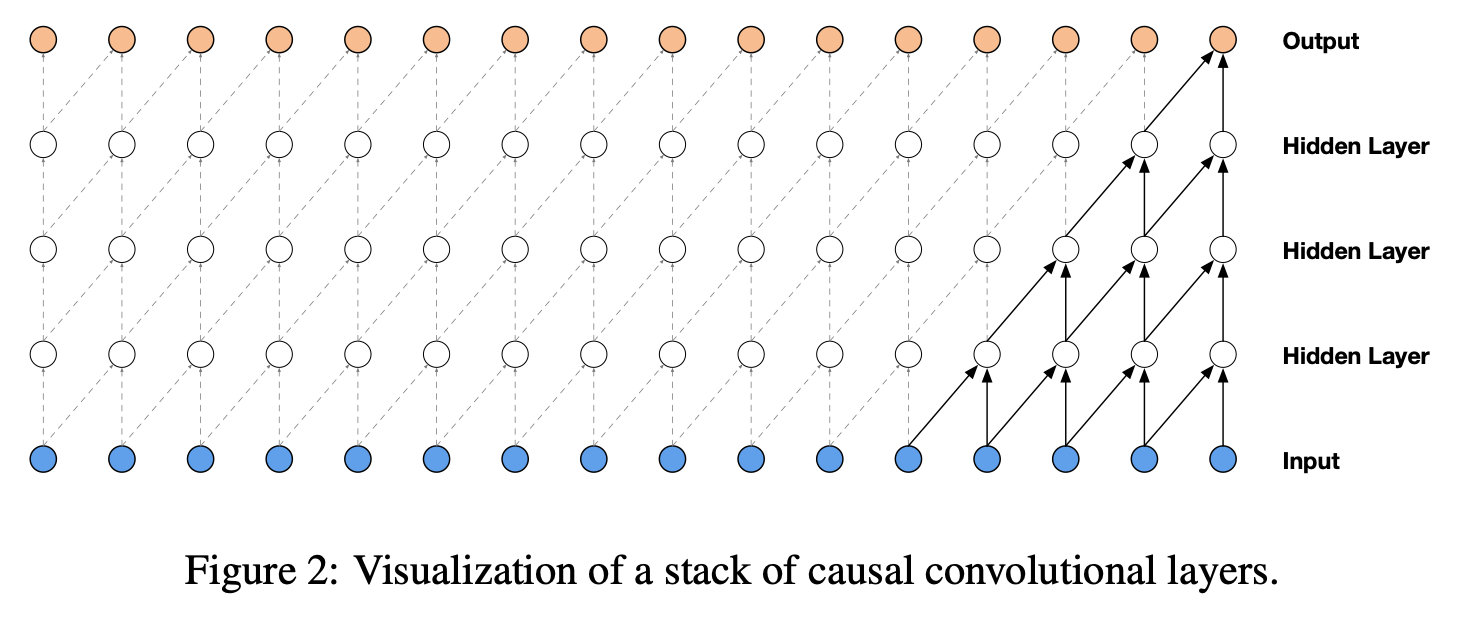

## Setting up a hierarchical network <a class="anchor" id="settingupnetwork">

We collect the modules `Linear`, `BatchNorm1d` and `Tanh` that we built in our previous notebook below in order to succintly build our model later.

In [6]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
  
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
  
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

We create a module `Embedding` that embeds data into another space. The number of data points embedded is given by the variable `num_embeddings` and the dimension of the embedding space is given by the variable `embedding_dim`.

In [7]:
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
  
    def parameters(self):
        return [self.weight]

To implement the WaveNet architecture we need to create a module `FlattenConsecutive` that will flatten consecutive entries in a systematic way.

The input is an integer `n` for the number of consecutive elements.

In [8]:
class FlattenConsecutive:
  
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
  
    def parameters(self):
        return []

To further simplify how we create our model we will use the module `Sequential`. The input to `Sequential` is a sequence of layers of our neural network so that the input to the neural network will be passed through the layers sequentially.

In [9]:
class Sequential:
  
    def __init__(self, layers):
        self.layers = layers
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
  
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

## Building a hierarchical network <a class="anchor" id="building">
    
With all the pieces defined in the previous section, we can now build the WaveNet architecture.

In [10]:
n_embd = 10 
n_hidden = 300
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), nn.Dropout(p=0.5),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), nn.Dropout(p=0.5),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), nn.Dropout(p=0.5),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
num_params = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {num_params}')
for p in parameters:
    p.requires_grad = True

Total number of parameters: 377130


## Training WaveNet <a class="anchor" id="train">
    
With the WaveNet model defined, we are now ready to train it.

In [11]:
m = model
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

max_steps = 100000
batch_size = 32
lossi = []
lossvali = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    logits = m(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
  
    # backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward(retain_graph=True)
  
    # optimise
    optimizer.step()

    # track stats and validation loss
    if i % 1000 == 0:
        with torch.no_grad():
            logits_valid = m(Xdev)
            loss_valid = F.cross_entropy(logits_valid, Ydev)
            lossvali.append(loss_valid.log10().item())
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    else:
        lossvali.append(loss_valid.log10().item())
    lossi.append(loss.log10().item())

      0/ 100000: 3.4074
   1000/ 100000: 2.3457
   2000/ 100000: 2.2000
   3000/ 100000: 1.9287
   4000/ 100000: 1.9891
   5000/ 100000: 2.1195
   6000/ 100000: 2.0172
   7000/ 100000: 2.2190
   8000/ 100000: 1.7932
   9000/ 100000: 2.1229
  10000/ 100000: 2.1508
  11000/ 100000: 1.8283
  12000/ 100000: 1.6892
  13000/ 100000: 1.6484
  14000/ 100000: 2.4289
  15000/ 100000: 1.6991
  16000/ 100000: 1.9429
  17000/ 100000: 1.7060
  18000/ 100000: 1.7135
  19000/ 100000: 1.7536
  20000/ 100000: 1.7134
  21000/ 100000: 1.2965
  22000/ 100000: 1.7185
  23000/ 100000: 1.7100
  24000/ 100000: 1.5345
  25000/ 100000: 1.9402
  26000/ 100000: 1.4439
  27000/ 100000: 1.9822
  28000/ 100000: 1.3486
  29000/ 100000: 1.8000
  30000/ 100000: 1.9893
  31000/ 100000: 1.6842
  32000/ 100000: 1.3861
  33000/ 100000: 1.7767
  34000/ 100000: 1.7836
  35000/ 100000: 1.6643
  36000/ 100000: 1.6209
  37000/ 100000: 1.6820
  38000/ 100000: 1.4746
  39000/ 100000: 1.3600
  40000/ 100000: 1.7357
  41000/ 100000:

Let's plot the training and validation loss over time to have an idea of how the training process went.

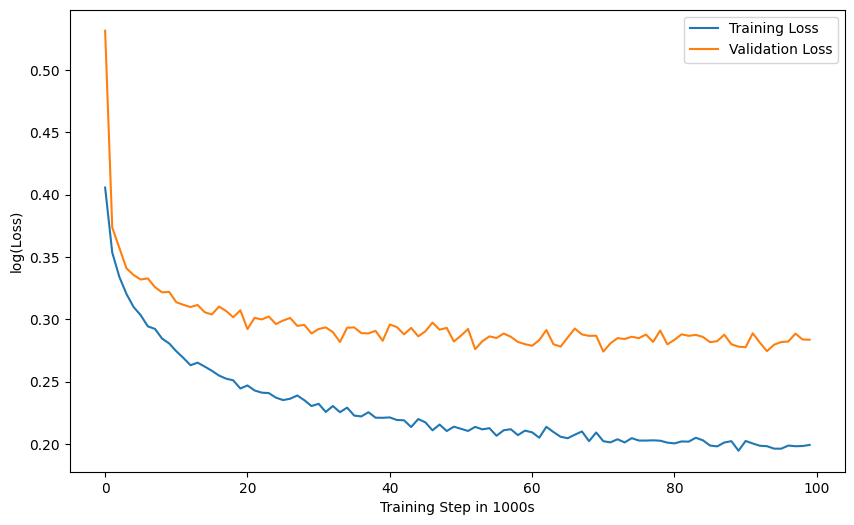

In [12]:
steps = list(range(0, int(max_steps/1000)))
loss_val = lossvali[0::1000]

plt.figure(figsize=(10, 6))
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1), label="Training Loss")
plt.plot(steps, loss_val, label="Validation Loss")
plt.xlabel("Training Step in 1000s")
plt.ylabel("log(Loss)")
plt.legend()
plt.show()

## Evaluating WaveNet <a class="anchor" id="eval">
    
With the model trained, let's evaluate how it performs on the training, validation and test sets.

In [13]:
# put layers into eval mode for batchnorm
for layer in model.layers:
    layer.training = False

In [14]:
@torch.no_grad()
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 1.1267812252044678
val 1.5680575370788574
test 1.623014211654663


The multi-layer perceptron model has a test loss of over 2.0, so the WaveNet model has significantly improved it. While the trianing loss is much lower than the validation loss and the test loss, we are not overfitting as our model is generalising well to the test set. 

## Sampling from WaveNet <a class="anchor" id="sample">
    
With our improved model, let's see what place names it generates!

In [15]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

aycleyle.
west shotterton inds.
hawden hill.
hamstatley.
lintz.
hedburn thornley.
wynybagate.
brookhall.
black hall broom.
blackhouse.
hareburn haups.
hunwiiddon.
blayth.
pitton.
high barnes.
new haugh.
bowlece nill.
the mill.
herlelfe casforpington.
north tyne.


These place names are, generally speaking, quite realistic!